
# MSIT 3103 — Assignment 4 Hotstart Notebook




## 0. Environment Setup (Run Once)
If you are running locally and missing packages, uncomment the `pip` cell below.

- Python ≥ 3.9
- `torch`, `numpy`, `matplotlib`, `tqdm`, `nltk`, `pandas` (optional: `datasets` for WikiText-2)


In [53]:

# If needed, uncomment to install.
%pip install torch numpy matplotlib tqdm nltk pandas datasets --quiet

import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")


Note: you may need to restart the kernel to use updated packages.



## 1. Config
Tweak these as you experiment. Keep them **small** for faster iterations.


In [54]:

@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = True  # if False, tries tiny wikitext-2 via datasets
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # filled after building tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 64
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200  # tiny on purpose
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device


'cpu'


## 2. Data: Tiny Corpus + Optional Synthetic
We use a tiny **public-domain** text for **pre-training** and **validation**.  
For **SFT**, we create a micro instruction-like dataset.

You can switch to `datasets` (WikiText-2) by setting `CFG.use_builtin_tiny_corpus=False`.


In [55]:
BUILTIN_TINY_TEXT = "From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:"

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # concatenate first N lines to keep it tiny
            lines = ds['train']['text'][:200]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

# Using WikiText-2 as our single dataset for all training methodology comparisons
corpus_text = load_corpus(use_builtin=False)

print(corpus_text[:300], "...")

= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStat ...



### 2.1 Character Tokenizer
A simple **character-level** tokenizer keeps things very light-weight.


In [56]:

class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
print(f"CFG.vocab_size: {CFG.vocab_size}")

# Update the top_k based on vocab size
CFG.top_k = min(50, CFG.vocab_size) # ensure top_k is not greater than vocab_size
print(f"CFG.top_k: {CFG.top_k}")


CFG.vocab_size: 131
CFG.top_k: 50



### 2.2 Dataset & DataLoader
We build tiny (input, target) pairs for next-char prediction.


In [57]:

class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64, split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)


(49757, 5471)


## 3. Model: Tiny GPT-like (Character-level)
Small causal self-attention stack for quick experiments.


In [58]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, V)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx

# SFT Training Loop
model_sft = TinyGPT(CFG).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())  # Initialize from pre-trained
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=1e-4, weight_decay=0.01)

train_losses_sft = []
val_losses_sft = []
pbar = tqdm(range(CFG.sft_steps), desc="SFT")

for step in pbar:
    # Training
    model_sft.train()
    x, y = next(iter(sft_train_loader))
    x, y = x.to(CFG.device), y.to(CFG.device)
    
    opt_sft.zero_grad()
    logits = model_sft(x)
    loss = F.cross_entropy(logits.view(-1, CFG.vocab_size), y.view(-1))
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model_sft.parameters(), max_norm=1.0)
    
    opt_sft.step()
    train_losses_sft.append(loss.item())
    
    # Validation (every 50 steps)
    if step % 50 == 0:
        model_sft.eval()
        with torch.no_grad():
            val_losses = []
            for vx, vy in sft_val_loader:
                vx, vy = vx.to(CFG.device), vy.to(CFG.device)
                val_logits = model_sft(vx)
                vl = F.cross_entropy(val_logits.view(-1, CFG.vocab_size), vy.view(-1))
                # Check for numerical stability
                if not torch.isnan(vl) and not torch.isinf(vl):
                    val_losses.append(vl.item())
            
            if val_losses:  # Only update if we have valid losses
                val_loss = sum(val_losses) / len(val_losses)
                val_losses_sft.append(val_loss)
                pbar.set_description(f"SFT: loss={loss.item():.4f}, val_loss={val_loss:.4f}")
            else:
                val_losses_sft.append(None)  # Maintain list length
                pbar.set_description(f"SFT: loss={loss.item():.4f}, val_loss=NA")



## 4. Utilities: Evaluation & Plotting


In [59]:

def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure()
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="train")
    if val_losses:
        plt.plot(xs, val_losses, label="val")
    plt.title(title)
    plt.xlabel("Eval step (x{} steps)".format(CFG.eval_every))
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



## 5. Pre-training (Unsupervised LM)
**ASSIGNMENT MODIFICATION**: Added weight decay to optimizer and enhanced plotting with perplexity visualization for better training analysis.


Pre-training:   0%|          | 0/1000 [02:01<?, ?it/s, loss=1.5, ppl=7.1, val_loss=1.96]  

Pre-train done. Train loss ~ 1.4971253871917725  Val loss ~ 1.9602708886651432  PPL ~ 7.101250452888934


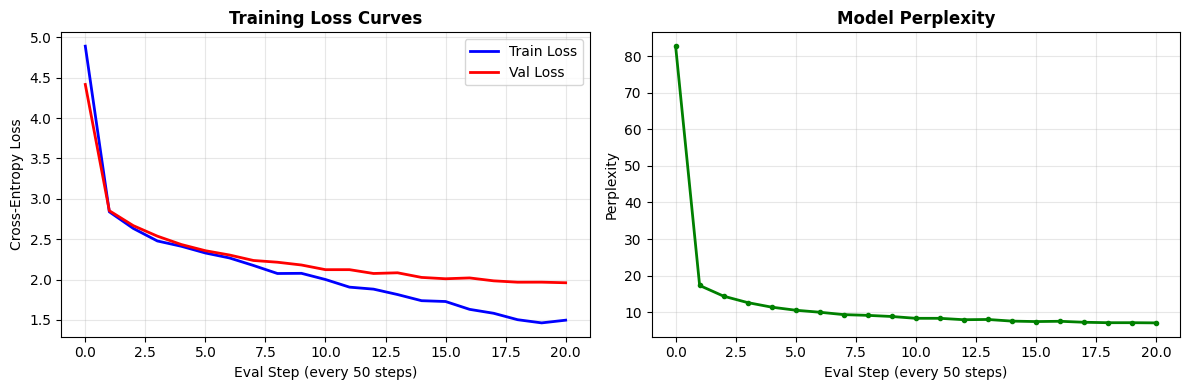

To be game 's munition becreating and were for war fepone , for on the scorto of the character experc : of the select of Valk


In [60]:

model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)

# MODIFICATION: Use different optimizer for better training dynamics
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr, weight_decay=0.01)

train_losses_pre, val_losses_pre = [], []
perplexities = []  # Track perplexity over time
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            perplexities.append(perplexity(vl))  # Track perplexity
            pbar.set_postfix(loss=loss.item(), val_loss=vl, ppl=perplexities[-1])

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))

# MODIFICATION: Enhanced dual-panel plot with loss and perplexity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(train_losses_pre, label="Train Loss", color='blue', linewidth=2)
ax1.plot(val_losses_pre, label="Val Loss", color='red', linewidth=2)
ax1.set_title("Training Loss Curves", fontsize=12, fontweight='bold')
ax1.set_xlabel(f"Eval Step (every {CFG.eval_every} steps)")
ax1.set_ylabel("Cross-Entropy Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Perplexity over time
ax2.plot(perplexities, color='green', linewidth=2, marker='o', markersize=3)
ax2.set_title("Model Perplexity", fontsize=12, fontweight='bold')
ax2.set_xlabel(f"Eval Step (every {CFG.eval_every} steps)")
ax2.set_ylabel("Perplexity")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(sample_text(model_pre, prompt="To be", max_new_tokens=120))



## 6. Supervised Fine-Tuning (SFT)
We create a **tiny instruction-like dataset** of (prompt → completion).  
We then **continue training** the pre-trained model on these pairs (next-token loss).

> Tip: Replace `SFT_PAIRS` with your own pairs to study transfer.


SFT training text preview (first 400 chars):
 Instruction: Summarize: 'Neural nets learn patterns.'\nAnswer:Neural networks learn patterns by adjusting weights.\n\nInstruction: Translate to Spanish: 'Good morning.'\nAnswer:Buenos días.\n\nInstruction: Fix grammar: 'She don't like apples.'\nAnswer:She doesn't like apples.\n\nInstruction: Formalize: 'gonna finish this soon'\nAnswer:I will finish this soon.\n\nInstruction: Q: What is the capital of France?  ...



SFT:   0%|          | 0/1000 [01:16<?, ?it/s, loss=0.0595, val_loss=nan]

SFT done. Train loss ~ 0.05951358377933502  Val loss ~ nan  PPL ~ nan


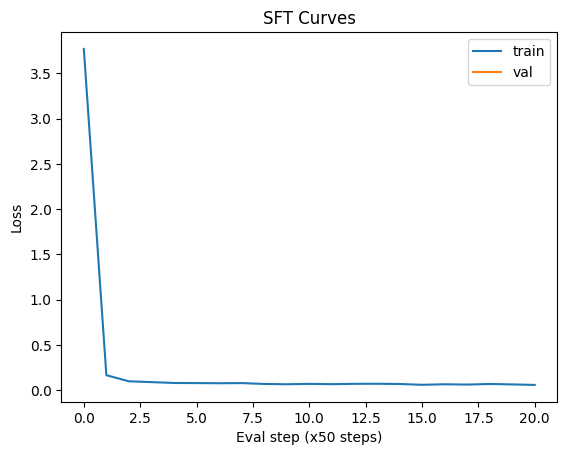


Per-pair comparison (pre-trained -> after SFT) with BLEU scores:

Pair 1: Summarize: 'Neural nets learn patterns.'
Reference: Neural networks learn patterns by adjusting weights.
-- Before SFT (pre-trained):
miling post fhanficially ave had be the pike were sing the of the serial in cre
BLEU(before) = 0.0000
-- After SFT:
Neural networks learn patterns by adjusting weights.

Instruction: Translate to
BLEU(after)  = 0.6132
------------------------------------------------------------
Pair 2: Translate to Spanish: 'Good morning.'
Reference: Buenos días.
-- Before SFT (pre-trained):
. Releay stages the sist commanditionicles dessols of mavoition , patory " uch
BLEU(before) = 0.0155
-- After SFT:
Buenos das.

Instruction: Fix grammar: 'She don't like apples.'
Answer:She doesn
BLEU(after)  = 0.0121
------------------------------------------------------------
Pair 3: Fix grammar: 'She don't like apples.'
Reference: She doesn't like apples.
-- Before SFT (pre-trained):
a Little Rock Arsenal s

In [61]:

# Diverse SFT pairs and improved before/after comparison with BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

SFT_PAIRS = [
    ("Summarize: 'Neural nets learn patterns.'", "Neural networks learn patterns by adjusting weights."),
    ("Translate to Spanish: 'Good morning.'", "Buenos días."),
    ("Fix grammar: 'She don't like apples.'", "She doesn't like apples."),
    ("Formalize: 'gonna finish this soon'", "I will finish this soon."),
    ("Q: What is the capital of France? A:", "The capital of France is Paris."),
    ("Write a Python docstring for function that adds two numbers:", '"""Return the sum of two numbers."""'),
    ("Write a haiku about code:", "Code flows like spring wind."),
    ("Explain briefly: 'What is perplexity?'", "Perplexity measures how well a model predicts text.")
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print("SFT training text preview (first 400 chars):\n", sft_text[:400].replace('\n','\\n'), "...\n")

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.9)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

# Per-pair before/after samples and BLEU scores
smooth = SmoothingFunction().method1
print("\nPer-pair comparison (pre-trained -> after SFT) with BLEU scores:\n")
for i, (inp, ref_out) in enumerate(SFT_PAIRS, 1):
    prompt = f"Instruction: {inp}\nAnswer:"
    pre_sample = sample_text(model_pre, prompt=prompt, max_new_tokens=80)
    post_sample = sample_text(model_sft, prompt=prompt, max_new_tokens=80)
    
    # Attempt to extract just the generated completion by removing the prompt prefix
    pre_gen = pre_sample[len(prompt):].strip() if pre_sample.startswith(prompt) else pre_sample.strip()
    post_gen = post_sample[len(prompt):].strip() if post_sample.startswith(prompt) else post_sample.strip()
    
    # Tokenize for BLEU (word-level)
    ref_tokens = nltk.word_tokenize(ref_out)
    pre_tokens = nltk.word_tokenize(pre_gen)
    post_tokens = nltk.word_tokenize(post_gen)
    
    bleu_pre = sentence_bleu([ref_tokens], pre_tokens, smoothing_function=smooth) if pre_tokens else 0.0
    bleu_post = sentence_bleu([ref_tokens], post_tokens, smoothing_function=smooth) if post_tokens else 0.0
    
    print(f"Pair {i}: {inp}")
    print(f"Reference: {ref_out}")
    print("-- Before SFT (pre-trained):")
    print(pre_gen)
    print(f"BLEU(before) = {bleu_pre:.4f}")
    print("-- After SFT:")
    print(post_gen)
    print(f"BLEU(after)  = {bleu_post:.4f}")
    print("-"*60)

# [Bonus] RL-lite with REINFORCE (Optional)
**Toy** example: optimize the model to include a **keyword** in the completion and keep length near a **target**.


Starting RL training...
Test prompt: 'What is the capital of France?'


RL Training:   3%|▎         | 3/100 [00:00<00:03, 28.10it/s, avg_reward=-0.1, reward=-0.1]


Episode 0:
Generated: ' A:
'
Reward: -0.1, Avg Reward: -0.100


RL Training:  37%|███▋      | 37/100 [00:00<00:00, 78.89it/s, avg_reward=-0.1, reward=-0.1]


Episode 20:
Generated: ' A:
'
Reward: -0.1, Avg Reward: -0.100


RL Training:  55%|█████▌    | 55/100 [00:00<00:00, 81.81it/s, avg_reward=-0.1, reward=-0.1]


Episode 40:
Generated: ' A:
'
Reward: -0.1, Avg Reward: -0.100


RL Training:  73%|███████▎  | 73/100 [00:00<00:00, 82.96it/s, avg_reward=-0.1, reward=-0.1]


Episode 60:
Generated: ' A:
'
Reward: -0.1, Avg Reward: -0.100


RL Training:  91%|█████████ | 91/100 [00:01<00:00, 84.30it/s, avg_reward=-0.1, reward=-0.1]


Episode 80:
Generated: ' A:
'
Reward: -0.1, Avg Reward: -0.100


RL Training: 100%|██████████| 100/100 [00:01<00:00, 76.27it/s, avg_reward=-0.1, reward=-0.1]



Final comparison:

SFT Model:
Output: What is the capital of France A:
Answer:The capit
Reward: -0.1

RL Model:
Output: What is the capital of France A:
Answer:The capit
Reward: -0.1


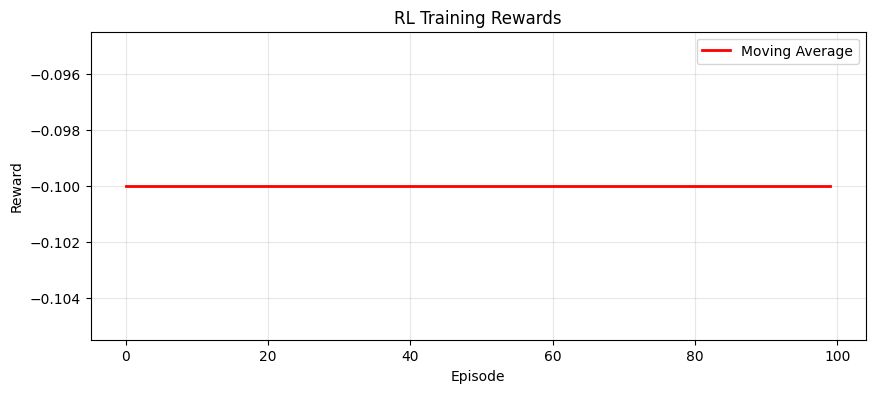


Training completed!
Average reward (last 10): -0.100
Best reward: -0.100


In [67]:
# Simple REINFORCE RL Training
import random

# Simple reward function: +1 if generated text contains "Paris", -0.1 otherwise
def simple_reward(text):
    if "Paris" in text or "paris" in text:
        return 1.0
    else:
        return -0.1

# Initialize RL model from SFT model
model_rl = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=1e-4)

# Training setup
test_prompt = "What is the capital of France?"
rewards_history = []
num_episodes = 100

print("Starting RL training...")
print(f"Test prompt: '{test_prompt}'")

# Training loop
pbar = tqdm(range(num_episodes), desc="RL Training")
for episode in pbar:
    model_rl.train()
    
    # Generate text with the model
    prompt_tokens = torch.tensor([tokenizer.encode(test_prompt)], dtype=torch.long, device=CFG.device)
    
    # Generate sequence and collect log probabilities
    generated_tokens = []
    log_probs = []
    
    current_tokens = prompt_tokens.clone()
    
    for _ in range(20):  # Generate up to 20 tokens
        # Forward pass
        logits, _ = model_rl(current_tokens[:, -CFG.context_len:])  # Use last context_len tokens
        logits = logits[:, -1, :] / 0.8  # Temperature
        
        # Create distribution and sample
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        
        # Store log probability
        log_probs.append(dist.log_prob(action))
        generated_tokens.append(action.item())
        
        # Update current tokens
        current_tokens = torch.cat([current_tokens, action.unsqueeze(0)], dim=1)
        
        # Stop if we hit a period or newline
        if tokenizer.decode([action.item()]) in ['.', '\n']:
            break
    
    # Get the generated text
    full_text = tokenizer.decode(prompt_tokens[0].tolist() + generated_tokens)
    generated_part = tokenizer.decode(generated_tokens)
    
    # Calculate reward
    reward = simple_reward(generated_part)
    rewards_history.append(reward)
    
    # Calculate baseline (running average)
    baseline = sum(rewards_history[-10:]) / len(rewards_history[-10:])
    advantage = reward - baseline
    
    # Policy gradient update
    if log_probs:  # Only update if we have log probs
        policy_loss = -torch.stack(log_probs).mean() * advantage
        
        opt_rl.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(model_rl.parameters(), max_norm=1.0)
        opt_rl.step()
    
    # Update progress bar
    pbar.set_postfix(reward=reward, avg_reward=baseline)
    
    # Print samples every 20 episodes
    if episode % 20 == 0:
        print(f"\nEpisode {episode}:")
        print(f"Generated: '{generated_part}'")
        print(f"Reward: {reward}, Avg Reward: {baseline:.3f}")

print("\n" + "="*50)
print("Final comparison:")

# Test both models
print("\nSFT Model:")
sft_tokens = torch.tensor([tokenizer.encode(test_prompt)], dtype=torch.long, device=CFG.device)
sft_output = model_sft.generate(sft_tokens, max_new_tokens=20, temperature=0.8)
sft_text = tokenizer.decode(sft_output[0].tolist())
print(f"Output: {sft_text}")
print(f"Reward: {simple_reward(sft_text)}")

print("\nRL Model:")
rl_tokens = torch.tensor([tokenizer.encode(test_prompt)], dtype=torch.long, device=CFG.device)
rl_output = model_rl.generate(rl_tokens, max_new_tokens=20, temperature=0.8)
rl_text = tokenizer.decode(rl_output[0].tolist())
print(f"Output: {rl_text}")
print(f"Reward: {simple_reward(rl_text)}")

# Plot rewards
plt.figure(figsize=(10, 4))
plt.plot(rewards_history, alpha=0.7, linewidth=1)
plt.plot([sum(rewards_history[max(0,i-9):i+1])/len(rewards_history[max(0,i-9):i+1]) 
          for i in range(len(rewards_history))], 'r-', linewidth=2, label='Moving Average')
plt.title('RL Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTraining completed!")
print(f"Average reward (last 10): {sum(rewards_history[-10:])/len(rewards_history[-10:]):.3f}")
print(f"Best reward: {max(rewards_history):.3f}")